In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import datetime
from dataclasses import dataclass
from typing import List

run_num = 0

In [44]:
cb_palette = sns.color_palette(as_cmap=True)

color_palette = {
    "Expected": cb_palette[0], 
    "expected": cb_palette[0], 
    "woltka": cb_palette[1], 
    "wol": cb_palette[1], 
    "jams": cb_palette[2], 
    "wgsa": cb_palette[3], 
    "wgsa2": cb_palette[3], 
    "biobakery3": cb_palette[4], 
    "bio3": cb_palette[4], 
    "biobakery4": cb_palette[5], 
    "bio4": cb_palette[5]
}

today = datetime.date.today()
date = today.strftime("%Y-%m-%d")

In [45]:
project_root = os.path.abspath("../../pipelines/")
# threshold = 0.0

# First, we load the data from the CSV file.
def find_stats_files(rank: str, threshold: bool):
    for root, dirs, files in os.walk(project_root):
        for file in files:
            # print(file)
            if f"all_stats_replicates_{rank}" in file and file.endswith('.csv'):
                stats_path = os.path.join(root, file)

                df = pd.read_csv(stats_path)

                if threshold:
                    # Add the threshold to the dataframe
                    threshold = file.split("_")[0]
                    if threshold == "all":
                        continue
                    elif threshold == "0.1":
                        continue
                    else:   
                        df["threshold"] = threshold
                
                yield stats_path, df

In [46]:
def combine_stats(rank: str, threshold_files: bool) -> pd.DataFrame:
    """
    Parameters:
        rank: str
            The rank to combine the stats for.
        threshold_files: bool
            Whether the files are thresholded or not.
    Returns:
        df: pd.DataFrame
            The combined dataframe.

    Combines the stats from all the different pipelines into one dataframe.
    """
    combined_df = pd.DataFrame()

    for path, df in find_stats_files(rank, threshold_files):
        df["Source"] = path.split("/")[-2]
        combined_df = pd.concat([combined_df, df])

    return combined_df

In [47]:
def make_catplot(df: pd.DataFrame, id_var: str, src: str, plot_type: str, pdf_output: PdfPages, title: str):
    melted = df.melt(id_vars=["SampleID", id_var, "Source"], var_name="Metric", value_name="Value").dropna()
    # Cast value column to float
    melted["Value"] = melted["Value"].astype(float)

    ax = sns.catplot(data=melted, x=id_var, y="Value", col="Metric", col_wrap=3, kind=plot_type, sharey=False, palette=color_palette)
    ax.fig.suptitle(title, y=1.05)

    pdf_output.savefig(ax.figure, bbox_inches='tight', dpi=300)
    plt.close(ax.figure)

def plot_stats(df: pd.DataFrame, output_pdf: str):
    pdf_output = PdfPages(output_pdf)
    # display(df.head(30))
    for th, th_df in df.groupby("threshold"):
        for src, df in th_df.groupby("Source"):
            title = f'Summary of Statistics for {src} at {th} Threshold'
            if src == "bmock12" or src == "camisimGI" or src =="nist":
                make_catplot(df, "Pipeline", src, "bar", pdf_output, title)

            else:
                no_average = df.loc[df['SampleID'] != 'Average']
                make_catplot(no_average, "Pipeline", src, "box", pdf_output, title)

    pdf_output.close()

In [48]:
def recode_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    recode_dict = {"wgsa": "wgsa2", "wol": "woltka", "bio4": "biobakery4"}

    df["Pipeline"].replace(recode_dict, inplace=True)


def cleanup_combined_df(df: pd.DataFrame) -> pd.DataFrame:
    # display(df.head(30))
    # If the Pipeline value is empty, then replace it with the value in "Source/Pipeline".
    try:
        df.loc[df["Pipeline"].isna(), "Pipeline"] = df.loc[df["Pipeline"].isna(), "Source/Pipeline"]
        # Drop the "Source/Pipeline" column.
        df = df.drop(columns=["Source/Pipeline"])
    except KeyError:
        print("Warning: No Source/Pipeline column found. Skipping...")
        pass

    # Drop rows where the SampleID is "Average".
    df = df.loc[df["SampleID"] != "Average"]

    # Recode the pipeline names.
    recode_pipeline(df)

    return df

In [49]:
# plot_stats(combine_stats("genus"), "stats_summary_genus.pdf")

combined_df = cleanup_combined_df(combine_stats("genus", True))
combined_df.to_csv(f"all_stats_genus_{today}.csv", index=False)

combined_df = cleanup_combined_df(combine_stats("species", True))
combined_df.to_csv(f"all_stats_species_{today}.csv", index=False)

# plot_stats(combined_df, "stats_summary_species.pdf")
# display(combined_df.head(30))

In [50]:
@dataclass
class Subset:
    pipelines: List[str]
    thresholds: List[float]
    sources: List[str]
    metrics: List[str]

# Only gather stats of interest...
replicates = Subset(
    pipelines = ["biobakery4", "jams202212", "wgsa2", "woltka"],
    thresholds = [0.0001],
    sources = ["mixed", "hilo", "tourlousse"],
    metrics = ["AD", "Sens", "FPRA"],
)

one_to_one = Subset(
    pipelines = ["biobakery4", "jams", "wgsa2", "woltka"],
    thresholds = [0.0001],
    sources = ["bmock12", "camisimGI", "nist"],
    metrics = ["AD", "Sens", "FPRA"],
)

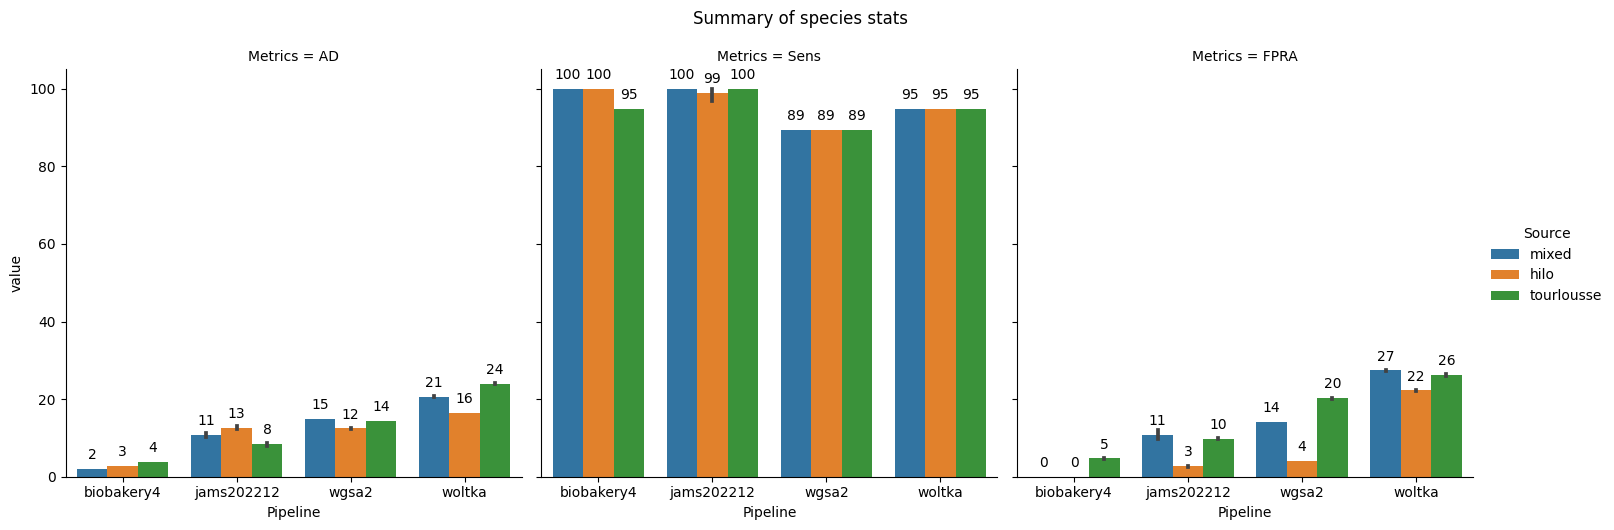

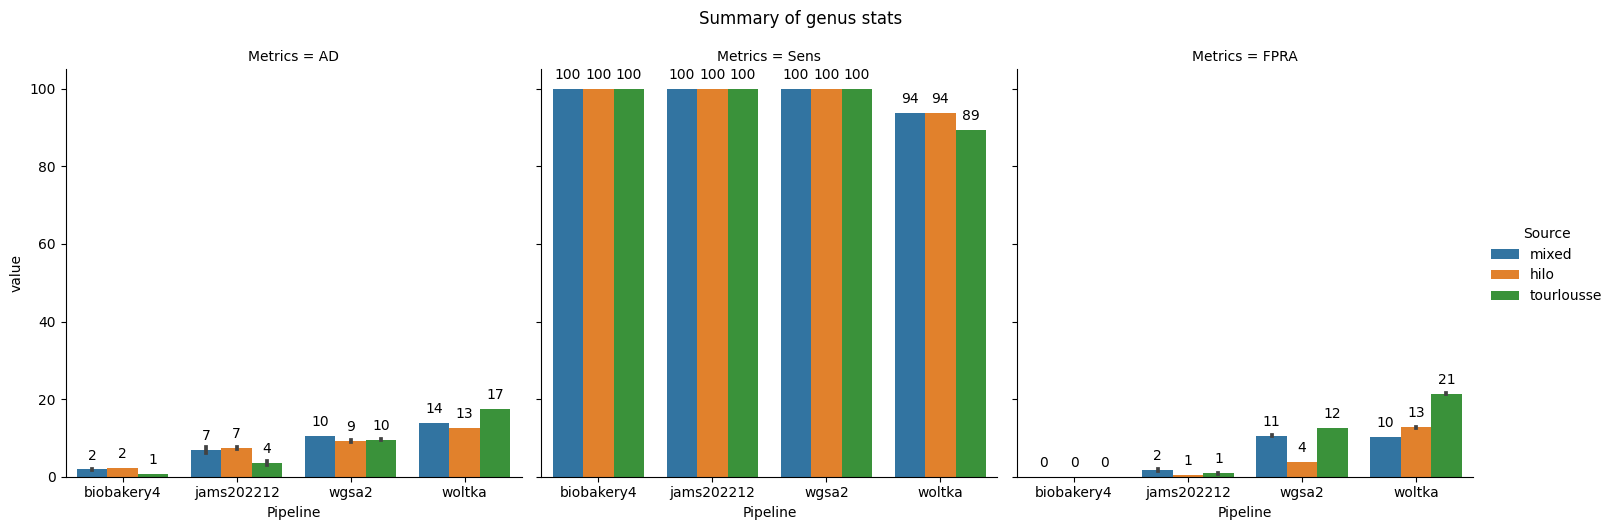

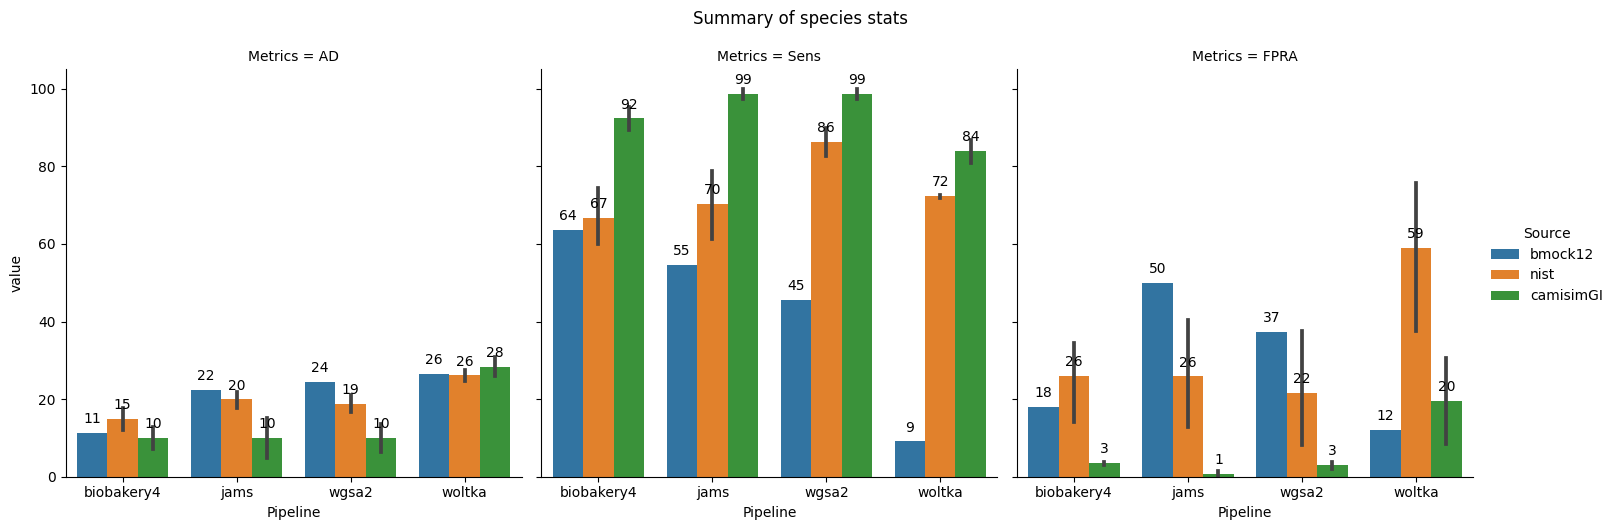

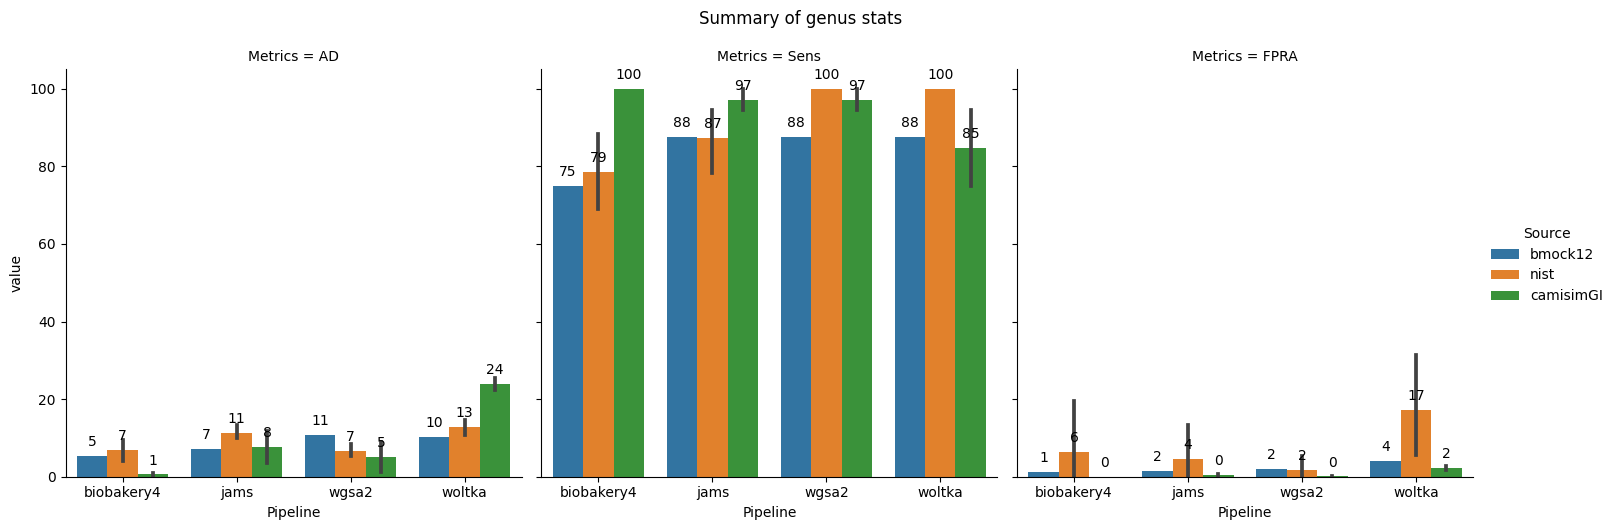

In [51]:

# Open the stats files:
stats_files = [f"all_stats_species_{today}.csv", f"all_stats_genus_{today}.csv"]

def subset_df(sub: Subset, save: bool = False):
    for sf in stats_files:
        df = pd.read_csv(sf)
        # display(df)
        df = df.loc[df["Pipeline"].isin(sub.pipelines)]
        df = df.loc[df["threshold"].isin(sub.thresholds)]
        df = df.loc[df["Source"].isin(sub.sources)]
        df["Run"] = run_num

        if save:
            df.to_csv(f"{sf.split('.')[0]}_subset.csv", index=False)
        
        rank = sf.split("_")[2].split(".")[0]
    
        yield df, rank


def plot_subset(sub: Subset): 
    for df, rank in subset_df(sub, save=True):
        id_vars = ["SampleID", "Pipeline", "Source"] + sub.metrics
        df = df[["SampleID", "Pipeline", "Source", "AD", "Sens", "FPRA"]]
        # display(df)
        df = df.melt(id_vars=["SampleID", "Pipeline", "Source"], var_name="Metrics", value_vars=["AD", "Sens", "FPRA"])
        # display(df.head(30))
        g = sns.catplot(data=df, kind="bar", x="Pipeline", col="Metrics", y="value", hue="Source")
        g.fig.suptitle(f"Summary of {rank} stats", y=1.05)

        # Add data labels
        for ax in g.axes.flat:
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
plot_subset(replicates)
plot_subset(one_to_one)